In [1]:
import pandas as pd
import time
import datetime
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./features.csv', index_col='match_id')

data.head()

start_time  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  \
match_id                                                                     
0         1430198770           7       11         5   2098     1489     20   
1         1430220345           0       42         4   1188     1033      9   
2         1430227081           7       33         4   1319     1270     22   
3         1430263531           1       29         4   1779     1056     14   
4         1430282290           7       13         4   1431     1090      8   

          r1_kills  r1_deaths  r1_items  ...  dire_boots_count  \
match_id                                 ...                     
0                0          0         7  ...                 4   
1                0          1        12  ...                 4   
2                0          0        12  ...                 4   
3                0          0         5  ...                 4   
4                1          0         8  ...                 3   

          dire_ward_observer_count  dire_ward_sentry_count  \
match_id                                                     
0                                2                       2   
1                                3                       1   
2                                3                       1   
3                                2                       0   
4                                3                       0   

          dire_first_ward_time  duration  radiant_win  tower_status_radiant  \
match_id                                                                      
0                        -52.0      2874            1                  1796   
1                         -5.0      2463            1                  1974   
2                         13.0      2130            0                     0   
3                         27.0      1459            0                  1920   
4                        -16.0      2449            0                     4   

          tower_status_dire  barracks_status_radiant  barracks_status_dire  
match_id                                                                    
0                         0                       51                     0  
1                         0                       63                     1  
2                      1830                        0                    63  
3                      2047                       50                    63  
4                      1974                        3                    63  

[5 rows x 108 columns]

# Подготовка

### Удаляем признаки, связанные с итогами матча 

In [4]:
features = data.drop(columns=['duration', 
                       'radiant_win', 
                       'tower_status_radiant', 
                       'tower_status_dire', 
                       'barracks_status_radiant', 
                       'barracks_status_dire'])

### Проверим выборку на наличие пропусков в данных

In [5]:
amounts = features.count()
rows_count = features.shape[0]
for i, am in enumerate(amounts):
    diff = rows_count - am
    if diff != 0:
        print(f"{features.columns[i]}: {diff}")

first_blood_time: 19553
first_blood_team: 19553
first_blood_player1: 19553
first_blood_player2: 43987
radiant_bottle_time: 15691
radiant_courier_time: 692
radiant_flying_courier_time: 27479
radiant_first_ward_time: 1836
dire_bottle_time: 16143
dire_courier_time: 676
dire_flying_courier_time: 26098
dire_first_ward_time: 1826


Из условия следует, что значения "первой крови" могут быть пропущенными в том, случае если она не произошла в первые пять минут. Признаки `*_bottle_time`, `*_courier_time`, `*_flying_courier_time` обозначают время приобретения соответствующего предмета, следовательно если они пропущены, то это событие не произошло в первые пять минут. Аналогично с признаком `*_first_ward_time`, пропуск обозначает, что установка первого  "наблюдателя" не произошла в первые пять минут. 

In [6]:
features = features.fillna(0)

### Целевая переменная -- `radiant_win`

In [7]:
target = data['radiant_win']

### Тестовая выборка

In [8]:
data_test = data_test.fillna(0)

# Обучение и оценка качества

### Подход 1: градиентный бустинг "в лоб"

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [10]:
kf5 = KFold(n_splits=5, shuffle=True)

In [11]:
times = []
cross_scores_lst = []
roc_scores_lst = []

In [12]:
for n in range(10, 110, 10):
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=n)
    cross_scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='roc_auc')
    end_time = datetime.datetime.now() - start_time
    clf.fit(X_train, y_train)
    roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f'{n} trees: {end_time}', cross_scores.mean(), roc_scores)
    times.append(end_time.total_seconds())
    cross_scores_lst.append(cross_scores.mean())
    roc_scores_lst.append(roc_scores)

10 trees: 0:00:29.708853 0.6632601218980765 0.6661692688322409
20 trees: 0:01:10.097573 0.6816167217447461 0.6827182974535684
30 trees: 0:01:35.008825 0.6883163874182237 0.692125886976204
40 trees: 0:02:20.689609 0.6938604900538685 0.6972051205029501
50 trees: 0:02:24.579698 0.6960778715216062 0.7004845314648054
60 trees: 0:02:54.862233 0.6983319265251607 0.7032697306473701
70 trees: 0:03:20.355378 0.7015901149127436 0.7048182620201564
80 trees: 0:03:50.529447 0.7030495408508652 0.7063627624733464
90 trees: 0:04:28.549401 0.7047771977413148 0.7078767256568677
100 trees: 0:05:04.574909 0.7050336707690189 0.7090162544118297


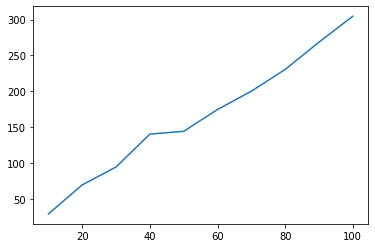

In [13]:
plt.plot(range(10, 110, 10), times)

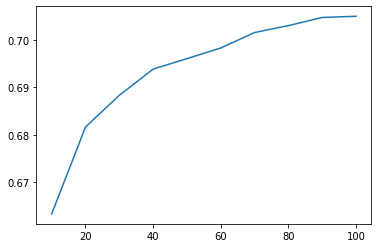

In [14]:
plt.plot(range(10, 110, 10), cross_scores_lst)

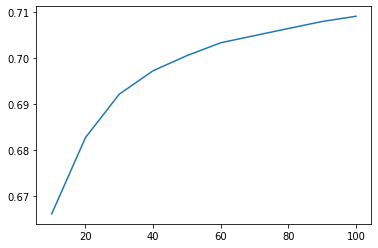

In [15]:
plt.plot(range(10, 110, 10), roc_scores_lst)

In [16]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=50, max_depth=2)
cross_scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='roc_auc')
end_time = datetime.datetime.now() - start_time
clf.fit(X_train, y_train)
roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f'50 trees: {end_time}', cross_scores.mean(), roc_scores)

50 trees: 0:01:36.587400 0.6904506587043462 0.6937407181544714


In [17]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=50, max_depth=1)
cross_scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='roc_auc')
end_time = datetime.datetime.now() - start_time
clf.fit(X_train, y_train)
roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f'50 trees: {end_time}', cross_scores.mean(), roc_scores)

50 trees: 0:00:50.013336 0.6767609633658307 0.6799760031348883


Видим, что время настройки прямопропорционально количеству деревьев. При этом качество обучения начинается колебаться вокруг 0.70 после 50 деревьев. Возможно, имеет смысл использовать больше 30 деревьев, если мы хотим получить оценку около 0.70. Однако придется пожертвовать скоростью работы. Уменьшение глубины дерева влияет на качество. 

### Подход 2: логистическая регрессия

#### Скейлинг 

In [25]:
times_log = []
cross_scores_lst_log = []
roc_scores_lst_log = []

scaler = StandardScaler().fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

for C in np.arange(0.1, 2.1, 0.1):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C, penalty='l2')
    cross_scores = cross_val_score(clf, X_train_scalled, y_train, cv=kf5, scoring='roc_auc')
    end_time = datetime.datetime.now() - start_time
    clf.fit(X_train_scalled, y_train)
    roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test_scalled)[:, 1])
    print(f'C={round(C, 2)}: {end_time}', cross_scores.mean(), roc_scores)
    times_log.append(end_time.total_seconds())
    cross_scores_lst_log.append(cross_scores.mean())
    roc_scores_lst_log.append(roc_scores)

C=0.1: 0:00:02.744565 0.7155747833955843 0.717205773321915
C=0.2: 0:00:02.758896 0.7157513795958004 0.717203751076057
C=0.3: 0:00:02.855136 0.7158396062299662 0.7172042803887313
C=0.4: 0:00:03.517595 0.7157542564044861 0.7172034524894203
C=0.5: 0:00:03.110847 0.715594445757757 0.7172036357130382
C=0.6: 0:00:02.830160 0.7157679384873967 0.7172032421215626
C=0.7: 0:00:03.058605 0.7153519263076797 0.7172037103596975
C=0.8: 0:00:03.209498 0.7158021664918491 0.7172036289269784
C=0.9: 0:00:03.664544 0.7156361261480239 0.7172026042319295
C=1.0: 0:00:03.317217 0.7157183108400172 0.7172028756743265
C=1.1: 0:00:03.420259 0.7159498494727391 0.7172030385397649
C=1.2: 0:00:02.787267 0.7158324033819277 0.7172028417440268
C=1.3: 0:00:03.380161 0.7157863018890841 0.7172028892464464
C=1.4: 0:00:03.326505 0.7155045647460673 0.7172029842512854
C=1.5: 0:00:02.932288 0.7156048514801855 0.7172030928282442
C=1.6: 0:00:03.910252 0.7154842745006127 0.7172030046094652
C=1.7: 0:00:02.733952 0.7155011136191549 0.

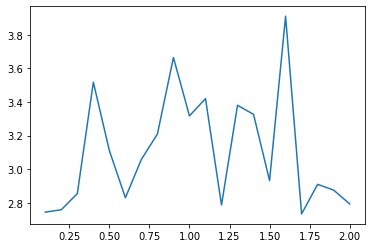

In [26]:
plt.plot(np.arange(0.1, 2.1, 0.1), times_log)

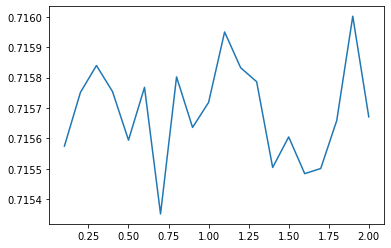

In [27]:
plt.plot(np.arange(0.1, 2.1, 0.1), cross_scores_lst_log)

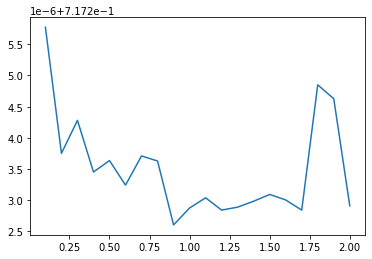

In [28]:
plt.plot(np.arange(0.1, 2.1, 0.1), roc_scores_lst_log)

Исходя из вышеприведенных графиков, можно сделать вывод о том, что параметр регуляризации С в данном случае не имеет сильного влияния на качество выборки. Качество колеблется вокруг 0.7172. Это немногим выше, чем при градиентном бустинге, что объясняется проведенным скейлингом данных. К тому же, логистическая регрессия работает в разы быстрее.

In [29]:
hero_columns = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

In [30]:
X_train = X_train.drop(columns=['lobby_type'] + hero_columns)
X_test = X_test.drop(columns=['lobby_type'] + hero_columns)

Убираем в существующей выборке, так как новая выборка может сама по себе поменять точость, поэтому эксперимент будет не чистым.

In [32]:
times_log = []
cross_scores_lst_log = []
roc_scores_lst_log = []

scaler = StandardScaler().fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

for C in np.arange(0.1, 2.1, 0.1):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C)
    cross_scores = cross_val_score(clf, X_train_scalled, y_train, cv=kf5, scoring='roc_auc')
    end_time = datetime.datetime.now() - start_time
    clf.fit(X_train_scalled, y_train)
    roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test_scalled)[:, 1])
    print(f'C={round(C, 2)}: {end_time}', cross_scores.mean(), roc_scores)
    times_log.append(end_time.total_seconds())
    cross_scores_lst_log.append(cross_scores.mean())
    roc_scores_lst_log.append(roc_scores)

C=0.1: 0:00:02.806623 0.7157701229075724 0.7173058677058296
C=0.2: 0:00:04.528078 0.7158727508439424 0.7173047955083611
C=0.3: 0:00:03.308410 0.7157787992370569 0.7173052501743763
C=0.4: 0:00:03.203769 0.7159006087172326 0.7173051551695373
C=0.5: 0:00:02.634404 0.7157035153137338 0.7173048972992602
C=0.6: 0:00:02.802631 0.7155517121129953 0.7173049719459194
C=0.7: 0:00:03.005569 0.7157833586678474 0.7173046462150429
C=0.8: 0:00:02.594424 0.7157942003971114 0.7173051348113575
C=0.9: 0:00:02.776934 0.7158116918452434 0.717304632642923
C=1.0: 0:00:02.619582 0.7161287736837624 0.7173053383931554
C=1.1: 0:00:02.665334 0.7158240729589875 0.7173049448016796
C=1.2: 0:00:02.667264 0.7158077450808711 0.7173048430107807
C=1.3: 0:00:02.594421 0.715578226554111 0.7173048769410802
C=1.4: 0:00:03.290895 0.715508593373243 0.7173048294386608
C=1.5: 0:00:02.996603 0.7155239643313684 0.7173048090804811
C=1.6: 0:00:03.631436 0.7156645849089079 0.7173048022944212
C=1.7: 0:00:02.722307 0.7160537146839413 0.

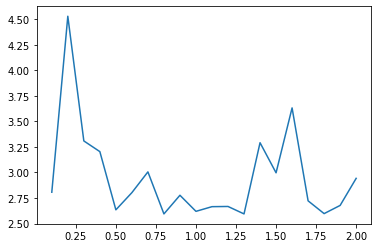

In [33]:
plt.plot(np.arange(0.1, 2.1, 0.1), times_log)

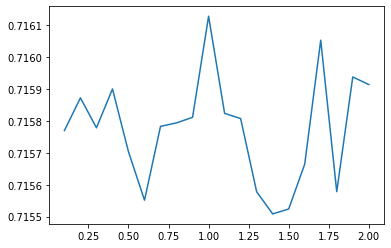

In [34]:
plt.plot(np.arange(0.1, 2.1, 0.1), cross_scores_lst_log)

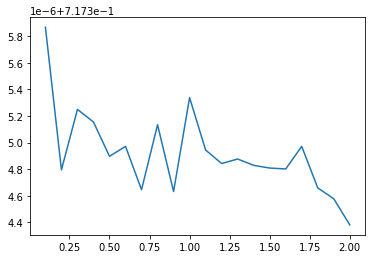

In [35]:
plt.plot(np.arange(0.1, 2.1, 0.1), roc_scores_lst_log)

Качество совсем незначительно увеличилось за счет удаления категориальных признаков, которые принимают дискретные значения и отображают принадлежность признака к какой-то категории. 

In [36]:
hero_ids = set()

In [37]:
for name, col in features[hero_columns].iteritems():
    hero_ids.update(col.unique())

In [38]:
len(hero_ids)

108

In [39]:
max(hero_ids)

112

In [42]:
X_pick = np.zeros((X_train.shape[0], max(hero_ids)))

for i, match_id in enumerate(X_train.index): 
    for p in range(5):
        X_pick[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [44]:
X_pick = pd.DataFrame(X_pick, index=X_train.index, columns=[f'{n}_hero' for n in range(max(hero_ids))])

In [45]:
X_train = pd.concat([X_train, X_pick], axis=1)

In [46]:
X_pick = np.zeros((X_test.shape[0], max(hero_ids)))

for i, match_id in enumerate(X_test.index): 
    for p in range(5):
        X_pick[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [47]:
X_pick = pd.DataFrame(X_pick, index=X_test.index, columns=[f'{n}_hero' for n in range(max(hero_ids))])

In [48]:
X_test = pd.concat([X_test,X_pick], axis=1)

In [55]:
times_log = []
cross_scores_lst_log = []
roc_scores_lst_log = []

scaler = StandardScaler().fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

for C in np.arange(0.1, 2.1, 0.1):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C)
    cross_scores = cross_val_score(clf, X_train_scalled, y_train, cv=kf5, scoring='roc_auc')
    end_time = datetime.datetime.now() - start_time
    clf.fit(X_train_scalled, y_train)
    roc_scores = roc_auc_score(y_test, clf.predict_proba(X_test_scalled)[:, 1])
    print(f'C={round(C, 2)}: {end_time}', cross_scores.mean(), roc_scores)
    times_log.append(end_time.total_seconds())
    cross_scores_lst_log.append(cross_scores.mean())
    roc_scores_lst_log.append(roc_scores)

C=0.1: 0:00:06.157639 0.7510044150173156 0.7526476678025513
C=0.2: 0:00:05.770869 0.7511799438303359 0.7526451026718991
C=0.3: 0:00:05.863959 0.7511039530704947 0.7526452180349179
C=0.4: 0:00:05.619558 0.7511383015447624 0.7526441322653297
C=0.5: 0:00:05.113717 0.7508863355656716 0.7526436504550749
C=0.6: 0:00:05.371717 0.7507870835244533 0.7526437454599139
C=0.7: 0:00:04.836008 0.7511254561363918 0.7526435350920562
C=0.8: 0:00:04.849097 0.7510669656274923 0.7526440033301911
C=0.9: 0:00:04.928089 0.7509730830505117 0.7526437929623333
C=1.0: 0:00:04.846297 0.7511381123344776 0.7526440440465506
C=1.1: 0:00:05.039033 0.7510500782873273 0.7526440711907902
C=1.2: 0:00:04.915664 0.7508548872329424 0.7526439693998914
C=1.3: 0:00:05.032849 0.750998537624118 0.7526446615780039
C=1.4: 0:00:04.952917 0.7510732659133813 0.7526440372604908
C=1.5: 0:00:04.745415 0.7511948739746466 0.7526439490417116
C=1.6: 0:00:04.920194 0.7510384443083491 0.752643820106573
C=1.7: 0:00:05.166070 0.75083603736409 0.7

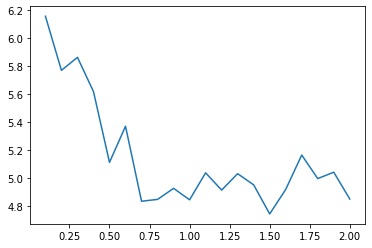

In [56]:
plt.plot(np.arange(0.1, 2.1, 0.1), times_log)

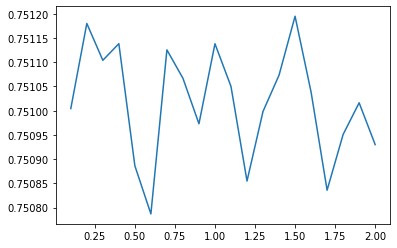

In [57]:
plt.plot(np.arange(0.1, 2.1, 0.1), cross_scores_lst_log)

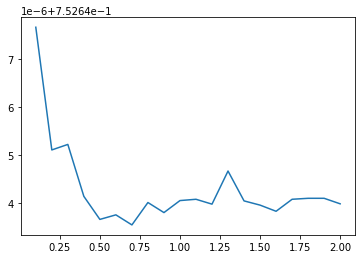

In [58]:
plt.plot(np.arange(0.1, 2.1, 0.1), roc_scores_lst_log)

Качество заметно улучшилось за счет того, что мы добавили преобразованные категориальные признаки, которые являются важными в этой задаче. 

## Предсказание для тестовой выборки

In [74]:
data_test = pd.read_csv('./features_test.csv', index_col='match_id')

data_test.head()

start_time  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  \
match_id                                                                     
6         1430287923           0       93         4   1103     1089      8   
7         1430293357           1       20         2    556      570      1   
10        1430301774           1      112         2    751      808      1   
13        1430323933           1       27         3    708      903      1   
16        1430331112           1       39         4   1259      661      4   

          r1_kills  r1_deaths  r1_items  ...  radiant_ward_sentry_count  \
match_id                                 ...                              
6                0          1         9  ...                          0   
7                0          0         9  ...                          2   
10               0          0        13  ...                          1   
13               1          1        11  ...                          2   
16               0          0         9  ...                          0   

          radiant_first_ward_time  dire_bottle_time  dire_courier_time  \
match_id                                                                 
6                            12.0             247.0              -86.0   
7                           -29.0             168.0              -54.0   
10                          -22.0              46.0              -87.0   
13                          -49.0              30.0              -89.0   
16                           36.0             180.0              -86.0   

          dire_flying_courier_time  dire_tpscroll_count  dire_boots_count  \
match_id                                                                    
6                            272.0                    3                 4   
7                              NaN                    3                 2   
10                           186.0                    1                 3   
13                           210.0                    3                 4   
16                           180.0                    1                 3   

          dire_ward_observer_count  dire_ward_sentry_count  \
match_id                                                     
6                                2                       0   
7                                2                       1   
10                               3                       0   
13                               2                       1   
16                               2                       1   

          dire_first_ward_time  
match_id                        
6                        118.0  
7                         16.0  
10                       -34.0  
13                       -26.0  
16                       -33.0  

[5 rows x 102 columns]

In [75]:
data_test = data_test.fillna(0)

X_pick = np.zeros((data_test.shape[0], max(hero_ids)))

for i, match_id in enumerate(data_test.index): 
    for p in range(5):
        X_pick[i, data_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
data_test = data_test.drop(columns=['lobby_type'] + hero_columns)        
X_pick = pd.DataFrame(X_pick, index=data_test.index, columns=[f'{n}_hero' for n in range(max(hero_ids))])
data_test = pd.concat([data_test,X_pick], axis=1)

In [76]:
scaler = StandardScaler().fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(data_test)

In [88]:
clf = LogisticRegression(C=0.1)
clf.fit(X_train_scalled, y_train)
pred = clf.predict_proba(X_test_scalled)[:, 1]

In [89]:
print('Min:', min(pred))
print('Max:', max(pred))

Min: 0.008085256262693206
Max: 0.9962568447697445


In [107]:
pred = pd.DataFrame(pred, columns=['radiant_win'])
pred['match_id'] = data_test.index
pred = pred.set_index('match_id')

In [108]:
pred.to_csv('prediction.csv')